# DSP experiments

This notebook contains DSP experiments to assess the accuracy of confidence level classification of climate statements by various LLMs.

In [ ]:
try: 
    # This library is our indicator that the required installs
    # need to be done.
    import datasets
    root_path = '.'
except ModuleNotFoundError:
    !git clone https://github.com/cgpotts/cs224u/
    !pip install -r cs224u/requirements.txt
    root_path = 'dsp'

Cloning into 'cs224u'...
remote: Enumerating objects: 2216, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 2216 (delta 55), reused 83 (delta 46), pack-reused 2092
Receiving objects: 100% (2216/2216), 41.49 MiB | 19.22 MiB/s, done.
Resolving deltas: 100% (1354/1354), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/stanfordnlp/dsp to /tmp/pip-req-build-x32h96un
  Running command git clone --filter=blob:none --quiet https://github.com/stanfordnlp/dsp /tmp/pip-req-build-x32h96un
  Resolved https://github.com/stanfordnlp/dsp to commit d4e6c1ac7f54986989640d5fb46108f0bd9cc802
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 96.2 MB

Now we import modules to work with DSP, OpenAI, HuggingFace, and Cohere models

In [ ]:
import cohere
from datasets import load_dataset
import openai
import re
import os
import dsp
import transformers

Now we import key variables such as API keys. Steps:

1) Create a keys.txt file in the root of your /content/ folder in the Colab instance

2) Define the API keys you will use 

3) Run the cell below to importan

In [ ]:
# Read the contents of the file
with open('/content/keys.txt', 'r') as file:
    file_contents = file.read()

# Assign the variables
exec(file_contents)

os.environ["DSP_NOTEBOOK_CACHEDIR"] = os.path.join(root_path, 'cache')
openai_key = OPENAI_API_KEY  
cohere_key = COHERE_API_KEY  

## Model setting

Now we define a choice of LM and setup the DSP environment.

In [ ]:
## We use the chatGPT AR-LM model

lm = dsp.GPT3(model = "gpt-3.5-turbo", api_key=openai_key, model_type="chat")
dsp.settings.configure(lm=lm)
dsp.settings.show_guidelines = True

### Loading the dataset
Upload a tab separated version of the dataset to /content/.

In [ ]:
import pandas as pd 

df = pd.read_csv('dataset.tsv', sep='\t', skiprows=0)
df_use = df[df['Use?'] == 1]
dataset = df_use[['text', 'confidence_rating']]
dataset.tail

<bound method NDFrame.tail of                                                    text confidence_rating
1     Mid-latitude storm tracks have likely shifted ...            medium
12    Human-induced climate change has contributed t...            medium
14    Increases in West African monsoon precipitatio...            medium
15    Event attribution studies and physical underst...              high
18    The observed average rate of heating of the cl...              high
...                                                 ...               ...
7439  Transport-related emissions in developing regi...              high
7442  Increased efficiency has been insufficient to ...              high
7493  The extent to which countries increase the amb...              high
7507  A significant push for international climate f...              high
7859  In short, future urban expansion will amplify ...         very high

[298 rows x 2 columns]>

In [ ]:
ipcc_sent = [dsp.Example(input=row['text'], label=row['confidence_rating'])
                    for _, row in dataset.iterrows()]

In [ ]:
ipcc_sent[:10]

[{'input': 'Mid-latitude storm tracks have likely shifted poleward in both hemispheres since the 1980s, with marked seasonality in trends ',
  'label': 'medium'},
 {'input': 'Human-induced climate change has contributed to increases in agricultural and ecological droughts15 in some regions due to increased land evapotranspiration16',
  'label': 'medium'},
 {'input': 'Increases in West African monsoon precipitation since the 1980s are partly due to the growing influence of GHGs and reductions in the cooling effect of human-caused aerosol emissions over Europe and North America',
  'label': 'medium'},
 {'input': 'Event attribution studies and physical understanding indicate that human-induced climate change increases heavy precipitation associated with tropical cyclones',
  'label': 'high'},
 {'input': 'The observed average rate of heating of the climate system increased from 0.50 [0.32 to 0.69] W m–2 for the period 1971–200619 to 0.79 [0.52 to 1.06] W m–2 for the period 2006–201820',
  

In [ ]:
print(len(ipcc_sent))

298


## Defining templates

### Zero-shot learning
Testing how models do on the task right out of the gate.

In [ ]:
Input = dsp.Type(
    prefix="Statement:", 
    desc="${the climate factoid the confidence level of which is to be assessed.}")

Label = dsp.Type(
    prefix="Confidence:", 
    desc="${a confidence level: 'low', 'medium', 'high', or 'very high'}")

zero_shot_template = dsp.Template(
    instructions="You are a helpful climate science and policy assistant, which accurately assesses the certainty level of facts about climate change extracted from the IPCC Assessment Reports.\n\nFor each statement presented to you, you will label the statement with exactly one of the following degrees of confidence: low, medium, high, or very high confidence.",
    input=Input(),
    output=Label())

Example:

In [ ]:
ex = dsp.Example(
    input=ipcc_sent[0]['input'], label=ipcc_sent[0]['label'])

ex.demos=dsp.sample(ipcc_sent, 0)

print(zero_shot_template(ex))

You are a helpful climate science and policy assistant, which accurately assesses the certainty level of facts about climate change extracted from the IPCC Assessment Reports.

For each statement presented to you, you will label the statement with exactly one of the following degrees of confidence: low, medium, high, or very high confidence.

---

Follow the following format.

Statement: ${the climate factoid the confidence level of which is to be assessed.}
Confidence: ${a confidence level: 'low', 'medium', 'high', or 'very high'}

---

Statement: Mid-latitude storm tracks have likely shifted poleward in both hemispheres since the 1980s, with marked seasonality in trends
Confidence:


## Defining the task

With zero shot we simply provide instructions and provide a format template, with no training demonstrations.

In [ ]:
@dsp.transformation
def assess_certainty(example): 
    
    example, completion = dsp.generate(zero_shot_template)(example, stage='zero-shot')

    return completion

Testing our task on the first sentence of the dataset: gpt3.5-turbo gets this first task right!

In [ ]:
assess_certainty(ex).label

'medium'

# First experiment

We assess the certainty level of the LM on the dataset, filter the output for extra "confidence" etc., then compare with ground truth.

In [ ]:
samples = dataset #.sample(50)

In [ ]:
samples['prediction'] = samples.text.apply(
    lambda x: re.findall(r"\b(?:low|medium|high|very high)\b", assess_certainty(dsp.Example(input=x, demos=dsp.sample(ipcc_sent, 0))).output.lower())[0])

INFO:backoff:Backing off request(...) for 0.5s (openai.error.RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID cc9de231e0c01c8e644373171ef01549 in your message.))


Backing off 0.5 seconds after 1 tries calling function <function GPT3.request at 0x7f7a72808ee0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.2s (openai.error.RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID a83415f7621072f4f48d850d117e0c2b in your message.))


Backing off 0.2 seconds after 1 tries calling function <function GPT3.request at 0x7f7a72808ee0> with kwargs {}


INFO:backoff:Backing off request(...) for 1.0s (openai.error.RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID f05f29343676acf3ad72e74f39265bea in your message.))


Backing off 1.0 seconds after 1 tries calling function <function GPT3.request at 0x7f7a72808ee0> with kwargs {}


INFO:backoff:Backing off request(...) for 1.0s (openai.error.RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 7981c552196a8f7e26a8849a0889f4e8 in your message.))


Backing off 1.0 seconds after 1 tries calling function <function GPT3.request at 0x7f7a72808ee0> with kwargs {}


INFO:backoff:Backing off request(...) for 0.6s (openai.error.RateLimitError: That model is currently overloaded with other requests. You can retry your request, or contact us through our help center at help.openai.com if the error persists. (Please include the request ID 485ee1dd93c41912a2ae7834d29ecff8 in your message.))


Backing off 0.6 seconds after 1 tries calling function <function GPT3.request at 0x7f7a72808ee0> with kwargs {}


<ipython-input-145-e03057c783cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples['prediction'] = samples.text.apply(


In [ ]:
samples['correct'] = samples.apply(
    lambda row: (row['confidence_rating'] == row['prediction']), axis=1)

samples['correct'].sum() / samples.shape[0]

<ipython-input-146-0eef760c6b07>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples['correct'] = samples.apply(


0.3624161073825503

In [ ]:
samples.head

<bound method NDFrame.head of                                                    text confidence_rating  \
1     Mid-latitude storm tracks have likely shifted ...            medium   
12    Human-induced climate change has contributed t...            medium   
14    Increases in West African monsoon precipitatio...            medium   
15    Event attribution studies and physical underst...              high   
18    The observed average rate of heating of the cl...              high   
...                                                 ...               ...   
7439  Transport-related emissions in developing regi...              high   
7442  Increased efficiency has been insufficient to ...              high   
7493  The extent to which countries increase the amb...              high   
7507  A significant push for international climate f...              high   
7859  In short, future urban expansion will amplify ...         very high   

     prediction  correct  
1          high   

In [ ]:
samples.to_csv('gpt3.5-turbo-zeroshot-exp1.csv', index=False)

## Precision, recall, and F1 score

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report

true_labels = samples['confidence_rating']
predicted_labels = samples['prediction']

# Compute macro F1 score
f1 = f1_score(true_labels, predicted_labels, average='macro')
print("Macro F1 score:", f1)

# Compute weighted F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print("Weighted F1 score:", f1)

# Compute precision for each class
precision = precision_score(true_labels, predicted_labels, average=None)

# Compute recall for each class
recall = recall_score(true_labels, predicted_labels, average=None)

# Compute F1 score for each class
f1 = f1_score(true_labels, predicted_labels, average=None)

# Create a dataframe to store precision and recall for each class
class_metrics_df = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1': f1})

# Add labels to the class metrics dataframe
class_metrics_df['Class'] = true_labels.unique().astype(str)

# Sort the dataframe by class index or name
class_metrics_df = class_metrics_df.sort_values('Class', key=lambda x: pd.Categorical(x, categories=["low", "medium", "high", "very high"]))

# Print class metrics dataframe
print(class_metrics_df)

# Compute accuracy for the whole system
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute accuracy by class

print("Accuracy (total):", accuracy)

report = classification_report(true_labels, predicted_labels, digits=4)
print(report)

# Count classes
category_counts = true_labels.value_counts()
print(category_counts)



Macro F1 score: 0.29361853203091287
Weighted F1 score: 0.3186479370663524
   Precision    Recall        F1      Class
2   0.169231  0.215686  0.189655        low
0   0.384615  0.765306  0.511945     medium
1   0.687500  0.154930  0.252874       high
3   0.500000  0.141026  0.220000  very high
Accuracy (total): 0.3624161073825503
              precision    recall  f1-score   support

        high     0.3846    0.7653    0.5119        98
         low     0.6875    0.1549    0.2529        71
      medium     0.1692    0.2157    0.1897        51
   very high     0.5000    0.1410    0.2200        78

    accuracy                         0.3624       298
   macro avg     0.4353    0.3192    0.2936       298
weighted avg     0.4501    0.3624    0.3186       298

high         98
very high    78
low          71
medium       51
Name: confidence_rating, dtype: int64


## Over/under confidence assessment

In [ ]:
value_map = {'low': 0, 'medium': 1, 'high': 2, 'very high': 3}

samples['predict_score'] = samples.prediction.apply(
    lambda x: value_map[x])

samples['true_score'] = samples.confidence_rating.apply(
    lambda x: value_map[x])

<ipython-input-153-9fc71b32cc7b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples['predict_score'] = samples.prediction.apply(
<ipython-input-153-9fc71b32cc7b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples['true_score'] = samples.confidence_rating.apply(


In [ ]:
samples['predict_score'].mean()

1.7483221476510067

In [ ]:
samples['true_score'].mean()

1.6140939597315436

In [ ]:
samples.loc[samples['true_score'] == 0, 'predict_score'].mean()

1.2112676056338028

In [ ]:
samples.loc[samples['true_score'] == 1, 'predict_score'].mean()

1.7254901960784315

In [ ]:
samples.loc[samples['true_score'] == 2, 'predict_score'].mean()

1.9285714285714286

In [ ]:
samples.loc[samples['true_score'] == 3, 'predict_score'].mean()

2.0256410256410255

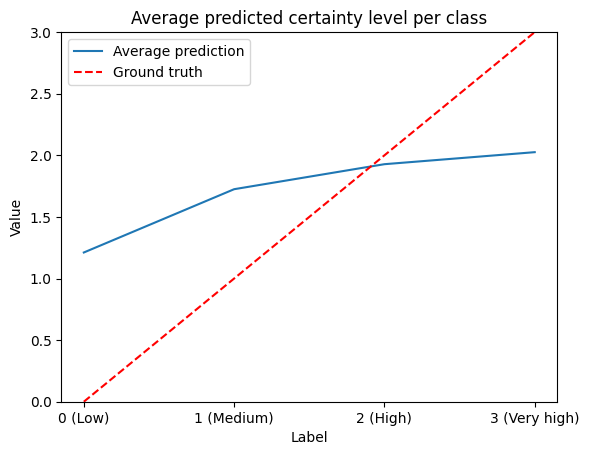

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the data
data = {
    "low": 1.2113,
    "medium": 1.725,
    "high": 1.928,
    "very high": 2.0256
}

# Extract labels and values from the data dictionary
labels = list(data.keys())
values = list(data.values())

# Define the custom labels for the x-axis
x_labels = ['0 (Low)', '1 (Medium)', '2 (High)', '3 (Very high)']

# Create the line plot with labeled curve
sns.lineplot(x=labels, y=values, label='Average prediction')
# Add the ground truth line (y = x)
x = np.arange(len(labels))
plt.plot(x, x, linestyle='--', color='red', label='Ground truth')

# Customize the x-axis tick labels
plt.xticks(labels, x_labels)

# Set the y-axis limits
plt.ylim(0, 3)

# Set the title and labels
plt.title("Average predicted certainty level per class")
plt.xlabel("Label")
plt.ylabel("Value")

# Show the legend
plt.legend()

# Show the plot
plt.show()